# Project Layout
The aim of this project is to perform player clustering and define which are the new roles of modern football.
The idea is to gruop players based on their tendencies and playstyle, forming clusters of physical player

In [13]:
from statsbombpy import sb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from mplsoccer import Pitch
import math

In [14]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
from scipy.spatial.distance import euclidean
from sklearn.metrics import jaccard_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [71]:
import matplotlib.patheffects as path_effects
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter

from mplsoccer import  VerticalPitch, FontManager, Sbopen

In [72]:
# fontmanager for google font (robotto)
robotto_regular = FontManager()

# path effects
path_eff = [path_effects.Stroke(linewidth=1.5, foreground='black'),
            path_effects.Normal()]

# see the custom colormaps example for more ideas on setting colormaps
pearl_earring_cmap = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors",
                                                       ['#15242e', '#4393c4'], N=10)

# The data
Extact event data from StatsBomb

In [15]:
real_madrid_matches=get_matches(competition_id=11, season_id=27, team='Real Madrid')
barca_matches=get_matches(competition_id=11, season_id=27, team='Barcelona')
atleti_matches=get_matches(competition_id=11, season_id=27, team='Atlético Madrid')
sevilla_matches=get_matches(competition_id=11, season_id=27, team='Sevilla')
real_madrid_matches.tail(1)

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
374,266424,2015-11-21,18:15:00.000,Spain - La Liga,2015/2016,Real Madrid,Barcelona,0,4,available,...,2021-06-13T16:17:31.694,12,Regular Season,Estadio Santiago Bernabéu,David Fernández Borbalan,Rafael Benítez Maudes,Luis Enrique Martínez García,1.1.0,2,2


In [40]:
carries=get_events(match_id=266424,event_type='Carry', player='Neymar da Silva Santos Junior')
carries.head(1)

,ball_receipt_outcome,ball_recovery_recovery_failure,block_deflection,block_save_block,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,clearance_left_foot,clearance_right_foot,...,shot_technique,shot_type,substitution_outcome,substitution_replacement,tactics,team,team_id,timestamp,type,under_pressure
2275,NaN,NaN,NaN,NaN,"[66.6, 4.3]",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Barcelona,217,00:01:22.968,Carry,True


In [41]:
dribbles=get_events(match_id=266424,event_type='Dribble', player='Neymar da Silva Santos Junior')
dribbles.head(1)

,ball_receipt_outcome,ball_recovery_recovery_failure,block_deflection,block_save_block,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,clearance_left_foot,clearance_right_foot,...,shot_technique,shot_type,substitution_outcome,substitution_replacement,tactics,team,team_id,timestamp,type,under_pressure
3415,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Barcelona,217,00:03:50.007,Dribble,True


In [34]:
dribbles.iloc[1].dropna()

dribble_outcome                                   Incomplete
duration                                                 0.0
id                      7695ca91-1d41-4d47-9d21-ea536d1e7892
index                                                   2432
location                                        [95.0, 77.3]
match_id                                              266424
minute                                                    53
period                                                     2
play_pattern                                  From Free Kick
player                                     Gareth Frank Bale
player_id                                             6399.0
position                           Center Attacking Midfield
possession                                               112
possession_team                                  Real Madrid
possession_team_id                                       220
related_events        [ff326bd1-69ad-4054-9b25-33162394c819]
second                  

In [29]:
dispossesion=get_events(match_id=266424,event_type='Dispossessed')
dispossesion.iloc[0].dropna()

duration                                                 0.0
id                      8bf42995-4aaf-4ddd-b18d-998a02e0f410
index                                                     54
location                                         [66.6, 4.3]
match_id                                              266424
minute                                                     1
period                                                     1
play_pattern                                   From Throw In
player                         Neymar da Silva Santos Junior
player_id                                             4320.0
position                                           Left Wing
possession                                                 3
possession_team                                    Barcelona
possession_team_id                                       217
related_events        [9da54508-dd36-496e-8d2a-7aaf059dbeb0]
second                                                    24
team                    

In [49]:
def carries_dribbles(c_df, d_df):
    carries_df = prepare_carries(c_df)
    dribbles_df=d_df.copy()
    dribbles_df[['x', 'y']]= d_df['location'].apply(lambda x: pd.Series({'x': x[0], 'y': x[1]}))
    success_dribs=dribbles_df[dribbles_df['dribble_outcome']!='Incomplete']
    unsuccess_dribs=dribbles_df[dribbles_df['dribble_outcome']=='Incomplete']
    # setup the pitch
    pitch = Pitch(pitch_color='grass', line_color='white')
    fig, ax = pitch.draw()
    # plot the completed passes arrows
    pitch.arrows(
        xstart=carries_df.x, ystart=carries_df.y, xend=carries_df.end_x,
        yend=carries_df.end_y, width=1, ax=ax, headwidth=10, headlength=10, color='#cccc00',
        label='Carries')
    pitch.scatter(success_dribs.x, success_dribs.y,
                   # size varies between 100 and 1000 (points squared)
                   s=150,
                   c='#b94b75',  # color for scatter in hex format
                   edgecolors='#383838',  # give the markers a charcoal border
                   # for other markers types see: https://matplotlib.org/api/markers_api.html
                   marker='*',
                   ax=ax, label='Successful Dribbles')
    pitch.scatter(unsuccess_dribs.x, unsuccess_dribs.y,
                   # size varies between 100 and 1000 (points squared)
                   s=50,
                   c='#606060',  # color for scatter in hex format
                   edgecolors='#383838',  # give the markers a charcoal border
                   # for other markers types see: https://matplotlib.org/api/markers_api.html
                   marker='h',
                   ax=ax, label='Unsuccesful Dribbles')

    #ax.set_title('Toni Kroos Passes vs Deportivo')
    # set the legend
    ax.legend(loc='upper left')
    plt.show()

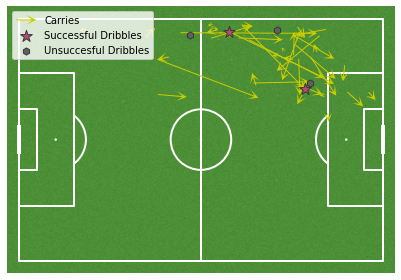

In [50]:
carries_dribbles(carries,dribbles)

In [31]:
pitch.scatter?

Object `pitch.scatter` not found.


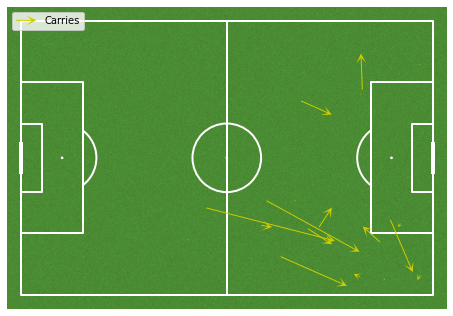

In [18]:
carries_arrows(prepare_carries(carries))

In [39]:
players=sb.lineups(match_id=267533)['Real Madrid'].append(sb.lineups(match_id=267533)['Barcelona'])
players=players.append(sb.lineups(match_id=3825621)['Atlético Madrid'])
players=players.append(sb.lineups(match_id=3825661)['Sevilla'])
players=players[['player_name','player_nickname']].reset_index()
players[18:36]

,index,player_name,player_nickname
18,0,Neymar da Silva Santos Junior,Neymar
19,1,Daniel Alves da Silva,Dani Alves
20,2,Claudio Andrés Bravo Muñoz,Claudio Bravo
21,3,Sergio Busquets i Burgos,Sergio Busquets
22,4,Jordi Alba Ramos,Jordi Alba
23,5,Gerard Piqué Bernabéu,Gerard Piqué
24,6,Andrés Iniesta Luján,Andrés Iniesta
25,7,Luis Alberto Suárez Díaz,Luis Suárez
26,8,Ivan Rakitić,None
27,9,Lionel Andrés Messi Cuccittini,Lionel Messi


In [57]:
touches_df=get_events(match_id=266424,event_type='Ball Receipt*', player='Neymar da Silva Santos Junior')
touches_df.iloc[0].dropna()

id                      0f1b0884-5e6a-4f29-a89c-26116590e428
index                                                     51
location                                         [66.6, 5.1]
match_id                                              266424
minute                                                     1
period                                                     1
play_pattern                                   From Throw In
player                         Neymar da Silva Santos Junior
player_id                                             4320.0
position                                           Left Wing
possession                                                 3
possession_team                                    Barcelona
possession_team_id                                       217
related_events        [3fe5fe0c-b407-4646-ab27-13a28ecada8b]
second                                                    22
team                                               Barcelona
team_id                 

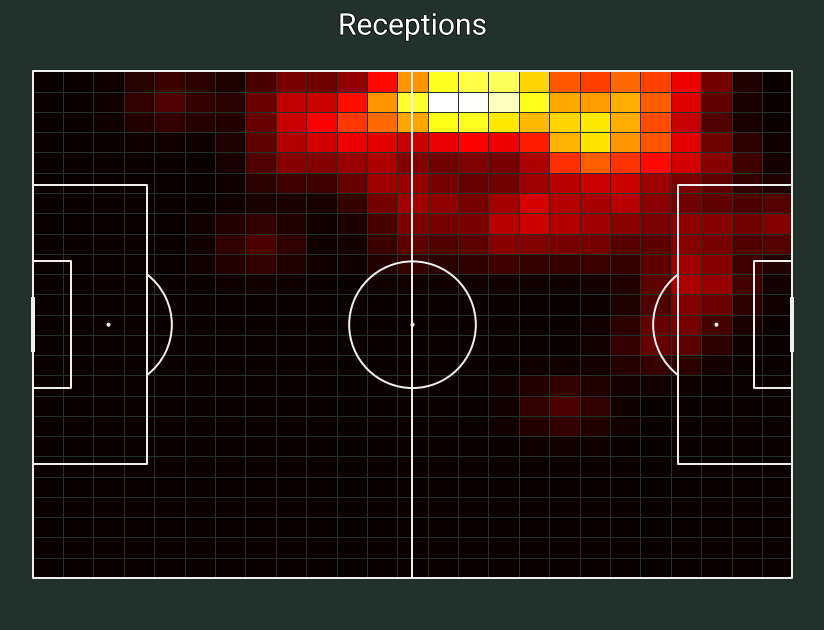

In [75]:
touches_df[['x','y']]=touches_df['location'].apply(lambda x: pd.Series({'x': x[0], 'y': x[1]}))
fig, axs = pitch.grid(endnote_height=0.03, endnote_space=0,
                      # leave some space for the colorbar
                      grid_width=0.88, left=0.025,
                      title_height=0.06, title_space=0,
                      # Turn off the endnote/title axis. I usually do this after
                      # I am happy with the chart layout and text placement
                      axis=False,
                      grid_height=0.86)
fig.set_facecolor('#22312b')
bin_statistic = pitch.bin_statistic(touches_df.x, touches_df.y, statistic='count', bins=(25, 25))
bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 1)
pcm = pitch.heatmap(bin_statistic, ax=axs['pitch'], cmap='hot', edgecolors='#22312b')

ax_title = axs['title'].text(0.5, 0.5, "Receptions", color='white',
                             va='center', ha='center', path_effects=path_eff,
                             fontproperties=robotto_regular.prop, fontsize=30)

In [77]:
def prepare_touches(touches_df):
    touches_df[['x', 'y']] = touches_df['location'].apply(lambda x: pd.Series({'x': x[0], 'y': x[1]}))
    touches_df['zone']=touches_df.apply(assign_startzone,axis=1)
    touches_df=touches_df[['zone', 'x','y']]
    return touches_df

In [90]:
def player_touch_map(touches_df):
    t_df=prepare_touches(touches_df)
    zone_t=t_df.groupby('zone').count()
    tpm=np.zeros(24)
    for i in range(24):
        if i in zone_t.index:
            tpm[i]=zone_t.loc[i,'x']
    return tpm

In [92]:
player_touch_map(touches_df)

array([ 0.,  0.,  0.,  0.,  2.,  1.,  0.,  0., 13.,  1.,  0.,  0., 21.,
        5.,  0.,  0., 20.,  4.,  2.,  0.,  4.,  7.,  0.,  0.])

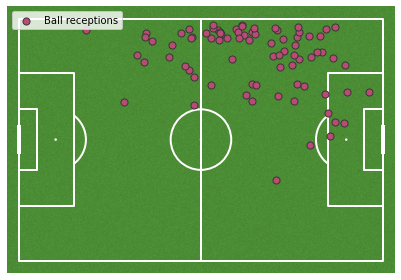

In [60]:
touches(touches_df)

In [20]:
matches=[real_madrid_matches,barca_matches, atleti_matches,sevilla_matches]

# Functions

In [3]:
def get_matches(competition_id, season_id, team=None):
    df=sb.matches(competition_id, season_id)
    if team!=None:
        df=df[(df['home_team']==team) | (df['away_team']==team)]
    return df

In [4]:
def get_events(match_id, event_type=None, player=None, team=None):
    df=sb.events(match_id=match_id)
    if event_type!=None:
        df=df[df['type']==event_type]
    if team != None:
        df=df[df['team']==team]
    if player!=None:
        df=df[df['player']==player]
    return df

In [5]:
def assign_startzone(pass_location):
    x=pass_location['x']
    y=pass_location['y']
    return 4*math.floor(x/20)+math.floor(y/20)
        
def assign_endzone(pass_location):
    x=pass_location['end_x']
    y=pass_location['end_y']
    return 4*math.floor(x/20)+math.floor(y/20)

In [6]:
def prepare_carries(carry_df):
    carry_df[['x', 'y']] = carry_df['location'].apply(lambda x: pd.Series({'x': x[0], 'y': x[1]}))
    carry_df[['end_x', 'end_y']] = carry_df['carry_end_location'].apply(lambda x: pd.Series({'x': x[0], 'y': x[1]}))
    carry_df['start_zone']=carry_df.apply(assign_startzone,axis=1)
    carry_df['end_zone']=carry_df.apply(assign_endzone,axis=1)
    carry_df=carry_df[['start_zone', 'end_zone','x','y','end_x','end_y']]
    return carry_df

In [7]:
def pass_network(match_id, team):
    event_df=get_events(match_id=match_id,team=team)
    pass_df = event_df[event_df.type == 'Pass']
    players_df=sb.lineups(match_id=match_id)[team]
    # boolean mask if the pass is completed
    pass_df[['x', 'y']] = pass_df['location'].apply(lambda x: pd.Series({'x': x[0], 'y': x[1]}))
    pass_df[['end_x', 'end_y']] = pass_df['pass_end_location'].apply(lambda x: pd.Series({'x': x[0], 'y': x[1]}))
    complete_pass_mask = pass_df.pass_outcome.isnull()
    completed_pass = pass_df[complete_pass_mask]
    # get first substitution minute
    subs = event_df[event_df.type == 'Substitution']
    first_sub_minute = subs['minute'].min()
    # passes before first sub
    completed_pass = completed_pass[completed_pass['minute'] < first_sub_minute]
    # players average passes location x, y , player_id => index
    avg_loc = completed_pass.groupby('player').agg({'x': ['mean'], 'y': ['mean']})
    avg_loc.columns = ['x', 'y']
    # pass between player_id and pass_recipient_id
    pass_between = completed_pass.groupby(['player', 'pass_recipient'], as_index=False).id.count()
    pass_between.columns = ['passer', 'recipient', 'passes_between']
    # merge avg_loc table with pass_between table throw passer column to get start x, y
    pass_between = pass_between.merge(avg_loc, left_on='passer', right_index=True)
    # merge avg_loc table with pass_between table throw recipient column to get end x, y
    pass_between = pass_between.merge(avg_loc, left_on='recipient', right_index=True, suffixes=['', '_end'])
    # setup the pitch
    pitch = Pitch(pitch_color='grass', line_color='white')
    fig, ax = pitch.draw()
    # plot passes network
    pitch.arrows(
        xstart=pass_between.x, ystart=pass_between.y, xend=pass_between.x_end,
        yend=pass_between.y_end, width=1, headwidth=10, headlength=30, color='#990000', ax=ax)
    # plot players
    pitch.scatter(
        x=pass_between.x, y=pass_between.y, s=250, color='red', edgecolor='black', linewidth=1, alpha=1, ax=ax)
    # plot players jersey number
    for index, row in avg_loc.iterrows():
        # index in avg_loc table is the player_id
        player_jersey_number = players_df[players_df.player_name == index].jersey_number.values[0]
        pitch.annotate(player_jersey_number, xy=(row.x, row.y), c='white', va='center', ha='center',
                       size=8, weight='bold', ax=ax)
    ax.set_title(f'{team} Pass Network')
    plt.show()


In [8]:
def carries_arrows(e):    
    carries_df = e
    # setup the pitch
    pitch = Pitch(pitch_color='grass', line_color='white')
    fig, ax = pitch.draw()
    # plot the completed passes arrows
    pitch.arrows(
        xstart=carries_df.x, ystart=carries_df.y, xend=carries_df.end_x,
        yend=carries_df.end_y, width=1, ax=ax, headwidth=10, headlength=10, color='#cccc00',
        label='Carries')
    # set the title
    #ax.set_title('Toni Kroos Passes vs Deportivo')
    # set the legend
    ax.legend(loc='upper left')
    plt.show()

In [9]:
def print_pass_clusters(total_pass, clustered_passes):
    pass_df = total_pass
    # boolean mask if the pass is completed
    complete_pass_mask = pass_df.pass_outcome.isnull()
    completed_passes = pass_df[complete_pass_mask]
    incomplete_passes = pass_df[~complete_pass_mask]
    # setup the pitch
    pitch = Pitch(pitch_color='grass', line_color='white')
    fig, ax = pitch.draw()
    # plot the completed passes arrows
    pitch.arrows(
        xstart=completed_passes.x, ystart=completed_passes.y, xend=completed_passes.end_x,
        yend=completed_passes.end_y, width=0.2, ax=ax, headwidth=5, headlength=5, color='#cccc00',
        label='Completed Passes')
    # plot the Incomplete passes arrows
    pitch.arrows(
        xstart=incomplete_passes.x, ystart=incomplete_passes.y, xend=incomplete_passes.end_x,
        yend=incomplete_passes.end_y, width=0.2, ax=ax, headwidth=5, headlength=5, color='#990000',
        label='Incomplete Passes')
    #plot the clusters
    pitch.arrows(
        xstart=clustered_passes.x, ystart=clustered_passes.y, xend=clustered_passes.end_x,
        yend=clustered_passes.end_y, width=1.5, ax=ax, headwidth=15, headlength=15, color='#0000FF',
        label='Clustered Passes')
    # set the title
    ax.set_title('Toni Kroos Passes vs Deportivo')
    # set the legend
    #ax.legend(loc='upper left')
    plt.show()

In [10]:
def pass_flow_map(e):
    pass_df = e
    # setup the pitch
    pitch = Pitch(pitch_color='grass', line_color='white', line_zorder=2)
    fig, ax = pitch.draw()
    # plot the heatmap (darker color means more passes from that square)
    bins = (6, 4)  # divide pitch to 6 columns and 3 rows
    bins_heatmap = pitch.bin_statistic(pass_df.x, pass_df.y, statistic='count', bins=bins)
    pitch.heatmap(bins_heatmap, ax=ax, cmap='Reds')
    # plot the arrows pass flow
    pitch.flow(
        xstart=pass_df.x, ystart=pass_df.y, xend=pass_df.end_x, yend=pass_df.end_y,
        ax=ax, color='black', arrow_type='same', arrow_length=5, bins=bins
    )
    ax.set_title('Pass Flow Map')
    plt.show()

In [11]:
def complete_pass_matrix(pass_df):
    complete_pass_mask = pass_df.pass_outcome.isnull()
    completed_passes = pass_df[complete_pass_mask]
    all_combinations = pd.DataFrame(columns=['start_zone', 'end_zone'])

    for start in range(0, 24):
        for end in range(0, 24):
            all_combinations = all_combinations.append({'start_zone': start, 'end_zone': end}, ignore_index=True)



    # Count the occurrences of each combination in the original DataFrame
    count = pass_df.groupby(['start_zone', 'end_zone']).size().reset_index(name='count')

    # Merge the counts with all_combinations DataFrame and fill missing values with 0
    result = pd.merge(all_combinations, count, on=['start_zone', 'end_zone'], how='left').fillna(0)

    # Pivot the DataFrame to get the desired 24x24 matrix
    return result.pivot(index='start_zone', columns='end_zone', values='count').fillna(0).to_numpy()

In [12]:
def season_pass_matrix(matches, player):
    pass_matrix=np.zeros([24,24])
    for index, match in matches.iterrows():
        match_id=match['match_id']
        passes=get_events(match_id=match_id,event_type='Pass', player=player)
        if len(passes)>0:
            passes=prepare_passes(passes)
            pass_matrix=pass_matrix+complete_pass_matrix(passes)
    return pass_matrix